# Detroit Housing Blight Notebook Part 1 :
# Data Cleaning and Exploratory Data Analysis

This notebook contains processes of data exploration and preliminary feature engineering with raw data.

1. Loading CSVs and checking/cleaning initial tables
2. Loading CSVs and checking/cleaning used tables
3. Creating new dataframe and feature engineering  
4. Initial EDA with dataframe
5. EDA after modeling

In [1]:
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.preprocessing import MinMaxScaler
import statsmodels.stats.api as sms
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import KFold
from sklearn import preprocessing
from itertools import combinations

In [177]:
pd.set_option('display.max_rows', 90)
pd.set_option('display.max_columns', 90)

# Data Cleaning and EDA

Load CSV files into pandas dataframes

# 1. Dropped tables
### 1.1 *Potental translation tables* - no longer relevant:

 These ended up being irrelevant to the final target, but were a part of the initial investigation and may be useful if crime or census tract-based data becomes relevant

In [59]:
census_geoid1 = pd.read_csv('Census_Block_Groups_Census_2010_Michigan.csv')
census_geoid1.head()

OBJECTID  STATEFP10  COUNTYFP10  TRACTCE10  BLKGRPCE10       GEOID10  \
0      7366         26         163     538400           1  261635384001   
1      7367         26         163     538100           1  261635381001   
2      7368         26         163     537800           3  261635378003   
3      7369         26         163     537800           2  261635378002   
4      7370         26         163     537800           1  261635378001   

      NAMELSAD10 MTFCC10 FUNCSTAT10  ALAND10  AWATER10  INTPTLAT10  \
0  Block Group 1   G5030          S   303493         0   42.429874   
1  Block Group 1   G5030          S   367927         0   42.442592   
2  Block Group 3   G5030          S   225740         0   42.389469   
3  Block Group 2   G5030          S   364088         0   42.392940   
4  Block Group 1   G5030          S   237831         0   42.392587   

   INTPTLON10     City  TractBG                              GlobalID  \
0  -83.136822  Detroit  5384001  4f36ea46-b851-4fc4-b484-b694f32019ca   
1  -83.139165  Detroit  5381001  c73f88bf-6605-4462-85f5-9f71317af601   
2  -83.185801  Detroit  5378003  3e6a4e7a-36c1-4b82-8ecd-0360a88e1f67   
3  -83.184911  Detroit  5378002  618f8cf7-b8a8-4092-81ea-4e3c7f8132ef   
4  -83.193778  Detroit  5378001  b13b92d2-01fe-4b72-9bff-e55e75b07a31   

    SqMiles      Acres  
0  0.117179  74.994753  
1  0.142057  90.916742  
2  0.087159  55.781569  
3  0.140575  89.968104  
4  0.091827  58.769320

In [2]:
# county , census tract and GEOID10
# census block 2010 : conversion info state&county FIPS code, census tract #, GEOID10, city
census_geoid = pd.read_csv('Census_Block_Groups_Census_2010_Michigan.csv')
census_geoid.drop(['BLKGRPCE10','MTFCC10', 'FUNCSTAT10', 'ALAND10', 'INTPTLAT10','INTPTLON10',
                   'GlobalID', 'SqMiles', 'AWATER10', 'TractBG'], axis=1, inplace=True)
census_geoid.columns = ['OBJECTID', 'STATEFP10', 'COUNTYFP10', 'CENSUSTRACT', 'GEOID10',
       'NAMELSAD10', 'City', 'Acres']
census_geoid['CENSUSTRACT'] = census_geoid['CENSUSTRACT'].apply(lambda x: x/100)
census_geoid.head()

OBJECTID  STATEFP10  COUNTYFP10  CENSUSTRACT       GEOID10     NAMELSAD10  \
0      7366         26         163       5384.0  261635384001  Block Group 1   
1      7367         26         163       5381.0  261635381001  Block Group 1   
2      7368         26         163       5378.0  261635378003  Block Group 3   
3      7369         26         163       5378.0  261635378002  Block Group 2   
4      7370         26         163       5378.0  261635378001  Block Group 1   

      City      Acres  
0  Detroit  74.994753  
1  Detroit  90.916742  
2  Detroit  55.781569  
3  Detroit  89.968104  
4  Detroit  58.769320

In [3]:
# County, entity, ANSI code
# FIPS state, county, entity, ANSI and GU codes with entity description
fips_codes = pd.read_excel('fips_codes_website.xls')
fips_codes = fips_codes.loc[fips_codes["State Abbreviation"] == 'MI']
fips_codes.head()

State Abbreviation  State FIPS Code  County FIPS Code  FIPS Entity Code  \
14578                 MI               26               139              1360   
14579                 MI               26               161              3020   
14580                 MI               26                69              4300   
14581                 MI               26               161              4180   
14582                 MI               26                17              5120   

       ANSI Code    GU Name Entity Description  
14578    1625822  Allendale   charter township  
14579    1625838  Ann Arbor   charter township  
14580    1625865   Au Sable   charter township  
14581    1625863    Augusta   charter township  
14582    1625878     Bangor   charter township

In [75]:
# zipcode to other tract..
zip_tract10 = pd.read_excel('TRACT_ZIP_122010.xlsx')

In [77]:
zip_tract10.loc[(zip_tract10['ZIP'] < 5000 )& (zip_tract10['ZIP'] > 4000)]

TRACT   ZIP  RES_RATIO  BUS_RATIO  OTH_RATIO  TOT_RATIO
55247  23001010100  4210   1.000000   1.000000   1.000000   1.000000
55248  23001010200  4210   0.997790   1.000000   1.000000   0.998300
55249  23001010200  4258   0.001326   0.000000   0.000000   0.001020
55250  23001010200  4282   0.000884   0.000000   0.000000   0.000680
55251  23001010300  4210   1.000000   1.000000   1.000000   1.000000
55252  23001010400  4210   1.000000   1.000000   1.000000   1.000000
55253  23001010500  4210   1.000000   1.000000   1.000000   1.000000
55254  23001010600  4210   1.000000   1.000000   0.976190   0.999211
55255  23001010600  4223   0.000000   0.000000   0.023810   0.000789
55256  23001010700  4210   0.992695   1.000000   1.000000   0.994076
55257  23001010700  4258   0.007305   0.000000   0.000000   0.005924
55258  23001010800  4210   0.998321   1.000000   1.000000   0.998385
55259  23001010800  4258   0.001679   0.000000   0.000000   0.001615
55260  23001020100  4240   1.000000   1.000000   1.000000   1.000000
55261  23001020200  4240   1.000000   1.000000   1.000000   1.000000
55262  23001020300  4240   1.000000   1.000000   1.000000   1.000000
55263  23001020400  4240   1.000000   1.000000   1.000000   1.000000
55264  23001020500  4240   1.000000   1.000000   1.000000   1.000000
55265  23001020600  4240   0.979757   1.000000   1.000000   0.983266
55266  23001020600  4250   0.020243   0.000000   0.000000   0.016734
55267  23001020700  4240   1.000000   1.000000   1.000000   1.000000
55268  23001020800  4240   1.000000   1.000000   1.000000   1.000000
55269  23001020900  4240   1.000000   1.000000   1.000000   1.000000
55270  23001030100  4240   0.007909   0.000000   0.000000   0.007473
55271  23001030100  4250   0.913989   0.941176   0.980000   0.916394
55272  23001030100  4252   0.078102   0.058824   0.020000   0.076133
55273  23001030200  4252   1.000000   1.000000   1.000000   1.000000
55274  23001040000  4210   0.016749   0.000000   0.000000   0.016514
55275  23001040000  4222   0.983251   1.000000   1.000000   0.983486
55276  23001041000  4015   0.001787   0.014925   0.000000   0.002141
55277  23001041000  4230   0.000000   0.000000   0.034483   0.000428
55278  23001041000  4260   0.006699   0.089552   0.000000   0.008994
55279  23001041000  4270   0.005806   0.000000   0.000000   0.005567
55280  23001041000  4274   0.985708   0.895522   0.931035   0.982441
55281  23001041000  4291   0.000000   0.000000   0.034483   0.000428
55282  23001041500  4210   0.002605   0.000000   0.000000   0.002468
55283  23001041500  4256   0.582718   0.901235   0.957447   0.600576
55284  23001041500  4258   0.409466   0.098765   0.021277   0.391608
55285  23001041500  4274   0.005211   0.000000   0.000000   0.004936
55286  23001041500  4288   0.000000   0.000000   0.021277   0.000411
55287  23001042000  4210   0.000485   0.000000   0.000000   0.000458
55288  23001042000  4220   0.000970   0.000000   0.000000   0.000916
55289  23001042000  4266   0.000000   0.000000   0.027778   0.000458
55290  23001042000  4282   0.998544   1.000000   0.972222   0.998168
55291  23001043000  4253   1.000000   1.000000   1.000000   1.000000
...            ...   ...        ...        ...        ...        ...
56039  23031022000  4049   0.999189   1.000000   1.000000   0.999205
56040  23031022500  4020   0.438144   0.846154   0.234043   0.443200
56041  23031022500  4028   0.000000   0.000000   0.021277   0.000800
56042  23031022500  4047   0.561856   0.153846   0.744681   0.556000
56043  23031023000  4048   1.000000   1.000000   1.000000   1.000000
56044  23031023500  4001   0.379890   0.232143   0.840909   0.384127
56045  23031023500  4056   0.000366   0.000000   0.022727   0.000705
56046  23031023500  4076   0.418647   0.660714   0.113636   0.418695
56047  23031023500  4095   0.201097   0.107143   0.022727   0.196473
56048  23031024000  4002   0.000416   0.000000   0.000000   0.000396
56049  23031024000  4030   0.278470   0.507937   0.254545   0.283677
56050  2303

In [114]:
parcels.ZONING.value_counts()

R1     187913
R2     132486
B4      20346
R3      10606
M4       7431
         4392
R5       3993
B2       3608
PD       2386
M3       1699
M2       1422
R6        934
SD2       669
SD4       626
R4        548
B5        519
B3        492
B6        307
M5        256
SD1       206
P1        199
PCA       111
B1         89
PR         76
TM         36
PC         26
SD5        23
W1          3
M1          2
Name: ZONING, dtype: int64

In [4]:
# getting table data from http://proximityone.com/ziptractequiv.htm#profiles
# for textarea in soup.findAll('textarea'):
#     contents = BeautifulSoup.BeautifulSoup(textarea.contents[0]).renderContents()
#     textarea.replaceWith(contents)

### 1.2 *Dropped Features* : could be used in the future
 These tables weren't included due to their organization by GEOID or census tract and not zip code. Could be included in future projects.

In [5]:
# GEOID10 & residential/business percent occupied 
zoning_vacancy = pd.read_csv('Addresses_Use_and_Vacancy_Block_Q42016.csv')
zoning_vacancy.drop(["GlobalID",'Shape__Area','Shape__Length'], axis=1,inplace=True)
zoning_vacancy.dropna(subset=['PctVAC'],inplace=True) # drop rows that don't contain % vacant
zoning_vacancy.head()

OBJECTID          GEOID10  OCC_RES  OCC_BUS  VAC_RES  VAC_BUS  \
0      1001  261635357002007     35.0      NaN     17.0      NaN   
3      1004  261635356003014     18.0      NaN      1.0      NaN   
4      1005  261635347004015      6.0      NaN      1.0      NaN   
5      1006  261635347004020      7.0      2.0      1.0      3.0   
6      1007  261635353005021     24.0      1.0      4.0      NaN   

   TotalAddresses  TotalOCC  TotalVAC  TotRES  TotBUS    PctVAC  
0              52        35        17      52       0  0.326923  
3              19        18         1      19       0  0.052632  
4               7         6         1       7       0  0.142857  
5              13         9         4       8       5  0.307692  
6              29        25         4      28       1  0.137931

In [8]:
# major crimes from 2011-2014 by CENSUS TRACT
crimes = pd.read_csv('Reported_Major_Crimes_2011_to_2014.csv')
crimes.drop(['OFFENSEDESCRIPTION','STATEOFFENSEFILECLASS','SCA','PRECINCT',
             'LOCATION','ObjectId'], axis=1, inplace=True)
crimes.dropna(inplace=True)
crimes['INCIDENTDATE'] = crimes['INCIDENTDATE'].apply(lambda x: int(x[:4]))
crimes.reset_index()

index   ROWNUM            CATEGORY  INCIDENTDATE  HOUR  \
0            0  1318073             LARCENY          2011    12   
1            2  1318077      STOLEN VEHICLE          2011     2   
2            3  1318079             LARCENY          2011    14   
3            4  1318080  AGGRAVATED ASSAULT          2011    15   
4            5  1318082            BURGLARY          2011    16   
5            6  1318086            BURGLARY          2011    12   
6            7  1318089            BURGLARY          2011    15   
7            8  1318091      STOLEN VEHICLE          2011     2   
8            9  1318092             ROBBERY          2011    15   
9           10  1318093      STOLEN VEHICLE          2011     6   
10          11  1318094      STOLEN VEHICLE          2011    15   
11          12  1318095            BURGLARY          2011    17   
12          13  1318097            BURGLARY          2011    11   
13          14  1318099             LARCENY          2011    18   
14          15  1318101            BURGLARY          2011    13   
15          16  1318105            BURGLARY          2011    17   
16          17  1318106             LARCENY          2011    17   
17          18  1318116      STOLEN VEHICLE          2011    19   
18          19  1318194            BURGLARY          2011    23   
19          20  1318117      STOLEN VEHICLE          2011     6   
20          21  1318118            BURGLARY          2011     7   
21          22  1318121             LARCENY          2011    18   
22          23  1318122             LARCENY          2011    13   
23          24  1318123            BURGLARY          2011    14   
24          25  1318126            BURGLARY          2011    15   
25          26  1318131  AGGRAVATED ASSAULT          2011    18   
26          27  1318132            BURGLARY          2011    17   
27          28  1318133            BURGLARY          2011    22   
28          29  1318135            BURGLARY          2011    15   
29          30  1318140             LARCENY          2011    16   
...        ...      ...                 ...           ...   ...   
215867  234942  1891522             LARCENY          2014     8   
215868  234943  1891524             LARCENY          2014    13   
215869  234944  1891524            BURGLARY          2014    13   
215870  234945  1891525             LARCENY          2014    13   
215871  234946  1891533            BURGLARY          2014    13   
215872  234947  1891540      STOLEN VEHICLE          2014    20   
215873  234948  1891541             LARCENY          2014    23   
215874  234950  1891543  AGGRAVATED ASSAULT          2014     2   
215875  234952  1891549            BURGLARY          2014    12   
215876  234953  1891551             LARCENY          2014    12   
215877  234954  1891552             LARCENY          2014     1   
215878  234955  1891553            BURGLARY          2014    15   
215879  234956  1891554             LARCENY          2014     1   
215880  234957  1891560             ROBBERY          2014    13   
215881  234959  1891567             ROBBERY          2014    14   
215882  234960  1891569            HOMICIDE          2014    15   
215883  234961  1891570             LARCENY          2014    14   
215884  234962  1891571      STOLEN VEHICLE          2014     1   
215885  234964  1891576             ROBBERY          2014    14   
215886  234966  1891578      STOLEN VEHICLE          2014     2   
215887  234967  1891579             LARCENY          2014    18   
215888  234968  1891584  AGGRAVATED ASSAULT          2014    15   
215889  234969  1891585  AGGRAVATED ASSAULT          2014    16   
215890  234970  1891587      STOLEN VEHICLE          2014    13   
215891  234972  1891591      STOLEN VEHICLE          2014    22   
215892  234973  1891592             LARCENY          2014    15   
215893  234974  1891597            BURGLARY          2014    15   
215894  234975  1891598      STOLEN VEHICLE          201

# 2. Final Features: some "lite" tables were kept
 The tables that were kept for this project were transformed into "lite" versions of the initial tables, with additional columns engineered from the raw tables 
### 2.1 *Rental Data Cleaning and EDA*: kept as 'rental_lite'
 Contains historical rental registration data for homes in Detroit 2003-2018. Final data from this kept as a boolean feature named 'rental' that contains a 1 if it was in this dataset.

In [3]:
hist_rentals = pd.read_csv('Rental_Registrations_HISTORIC.csv')
hist_rentals.drop(hist_rentals.loc[hist_rentals.parcelnum.isnull()].index,inplace=True)
# add this feature in a later iteration
# hist_rentals['athome_owner'] = [True if str(hist_rentals['address'][i]).lower() == str(rentals['owner_address'][i]).lower() else (False) for i in range(len(rentals))]

In [435]:
hist_rentals.csm_recd_date.apply(lambda x: x[:4]).value_counts()

2018    3830
2004    1868
2017    1791
2005    1250
2016     953
2012     716
2006     584
2010     471
2008     464
2009     389
2013     375
2015     364
2011     326
2014     320
2007     299
2003     200
Name: csm_recd_date, dtype: int64

In [179]:
hist_rentals.head()

X          Y     csm_caseno csm_name_first  \
0 -83.191594  42.366442  PMB2004-08763            NaN   
1 -83.096351  42.370188  PMB2004-08766            NaN   
2 -83.097054  42.369922  PMB2004-08771            NaN   
3 -83.098488  42.369382  PMB2004-08774            NaN   
4 -83.245310  42.405536  PMB2004-08844      STARRLETT   

             csm_name_last csm_name_mi csm_recd_by             csm_recd_date  \
0  UNIQUE HOME RENTALS LLC         NaN     BLACKSL  2004-06-25T00:00:00.000Z   
1        LEXINGTON VILLAGE         NaN     SPENCET  2004-06-25T00:00:00.000Z   
2        LEXINGTON VILLAGE         NaN     SPENCET  2004-06-25T00:00:00.000Z   
3        LEXINGTON VILLAGE         NaN     SPENCET  2004-06-25T00:00:00.000Z   
4                  JACKSON         NaN    WORDLAWT  2004-06-25T00:00:00.000Z   

        address   parcelnum           action_description  \
0   9558 ROBSON   22043465.  Issue Initial Registration    
1   1941 EUCLID  08002072-9   Issue Renewal Registration   
2   1981 EUCLID  08002072-9   Issue Renewal Registration   
3   2053 EUCLID  08002082-6   Issue Renewal Registration   
4  15763 BRAILE   22105664.   Issue Renewal Registration   

          csa_creation_date  csa_date1  csa_date2                 csa_date3  \
0  2018-01-23T12:36:52.000Z        NaN        NaN  2018-01-23T00:00:00.000Z   
1  2017-03-15T10:55:00.000Z        NaN        NaN  2017-03-15T00:00:00.000Z   
2  2017-03-15T10:53:34.000Z        NaN        NaN  2017-03-15T00:00:00.000Z   
3  2017-03-15T10:51:55.000Z        NaN        NaN  2017-03-15T00:00:00.000Z   
4  2017-12-12T12:05:10.000Z        NaN        NaN  2017-12-12T00:00:00.000Z   

  csa_disp  pmb_dwelling_units pmb_type_use csm_status case_type  ObjectId  
0     DONE                 1.0       SINGLE        DAH       PMB      1001  
1     DONE                 8.0        APART        COC       PMB      1002  
2     DONE                 8.0         TOWN                  PMB      1003  
3     DONE                 8.0        APART        COC       PMB      1004  
4     DONE                 1.0       SINGLE        REG       PMB      1005

In [4]:
rent_lite = pd.DataFrame(hist_rentals['parcelnum'].unique(), 
                         columns=['PARCELNUM'])
rent_lite['PARCELNUM'] = rent_lite['PARCELNUM'].apply(lambda x: x[:-1] if x[-1] == '.' else x) #clean up last .
rent_lite['rental'] = np.ones(len(rent_lite))

##  2.2 *Blight Data and EDA*: kept as 'blight_lite' - contains feature
 Contains information about homes that have recieved a citiation for blighting on their homes. Engineered two columns: **total_tickets** (many parcels had more than one), and **total_due_parcel** which contained the sum of all tickets owed on that parcel. **total_tickets** was then made into a boolean feature and used as the target variable in the final dataframe.

In [8]:
# WARNING: will take a long time
blight = pd.read_csv('Blight_Violations_DAH.csv')
blight.drop(blight.loc[blight.parcelno == 'CONDO BUILDING'].index, inplace=True) #only non-condos
blight.drop(blight.loc[blight.city.lower() != 'detroit'].index, inplace=True) #only detroit homes
# generate column with total notifications total per parcel
blight['total_tickets'] = blight.parcelno.apply(lambda x: \
                                                blight.loc[blight.parcelno == x].shape[0])
# generate column with total sum owed per parcel
blight['total_due_parcel'] = blight.parcelno.apply(lambda x: blight.loc[blight.parcelno == x].\
                                                   balance_due.sum())

In [10]:
blight_lite = blight[['parcelno', 'total_due_parcel','total_tickets']]
blight_lite.columns = ['PARCELNUM','total_due_parcel','total_tickets']
blight_lite['PARCELNUM'] = blight_lite['PARCELNUM'].apply(lambda x: str(x)[:-1] if str(x)[-1] == '.' else str(x)) #clean up last .
blight_lite.drop_duplicates('PARCELNUM', inplace=True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [427]:
# barplot of total tickets due vs total amount due per parcel
sns.set(rc={'figure.figsize':(11.7,8.27)})
g = sns.barplot(blight_lite['total_tickets'], 
            blight_lite['total_due_parcel'], palette='Blues_d');
g.set(ylim=(0, 175000))
# g.set(ylim=(0, 2200000))
g.set(xlabel='total tickets', ylabel='total due (USD)',title='Blight Tickets vs Amount Due');

**Note:** det_blight kept as a table to explore aspects of a table with more relevant information

In [265]:
det_blight = blight[(blight['city'] == 'detroit') | (blight['city'] == 'Detroit') |\
                   (blight['city'] == 'DETROIT')| (blight['city'] == 'DETROIT ')]

In [303]:
det_blight.zip_code.value_counts()
det_blight['zip_lite'] = det_blight.violation_zip_code.apply\
(lambda x: str(x)[-4:-2] if str(x)[-2:]== '.0' else str(x)[:3])
det_blight.drop(det_blight[det_blight['zip_lite'] != '482'].index, inplace=True)
det_blight.drop(det_blight[(det_blight['violation_zip_code'] == '482') |\
                           (det_blight['violation_zip_code'] == '482O5') |\
                           (det_blight['violation_zip_code'] == '482 ') |\
                           (det_blight['violation_zip_code'] == '482`5') |\
                            (det_blight['violation_zip_code'] == '48229') |\
                            (det_blight['violation_zip_code'] == '482ST') |\
                          (det_blight['violation_zip_code'] == ' ')].index, inplace=True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


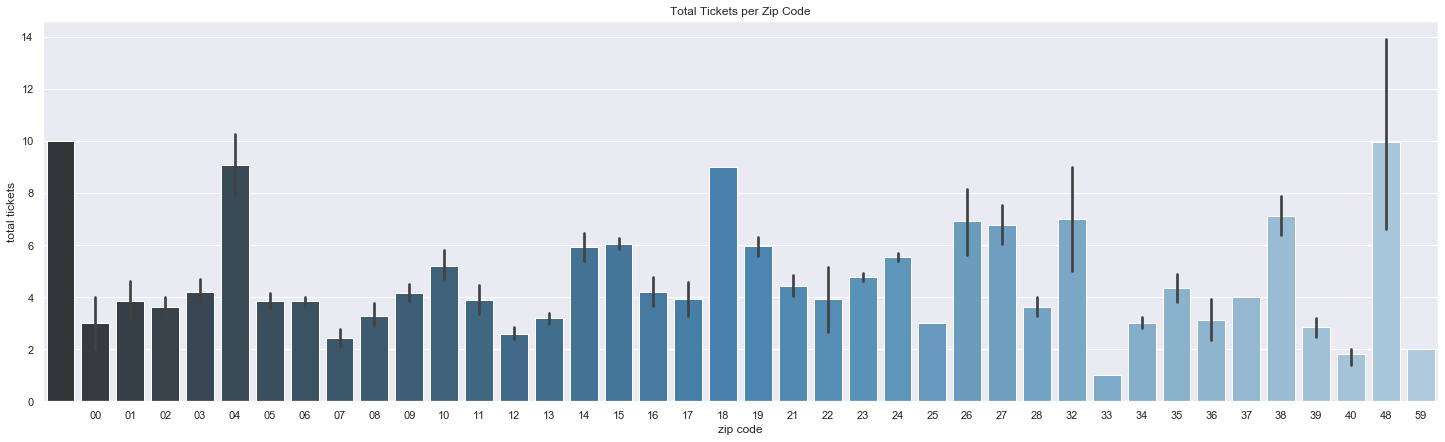

In [424]:
# plot zip codes against total tickets in det_blight
zips = det_blight.violation_zip_code.dropna().apply(lambda x: str(x)[-2:]).sort_values()
sns.set_style("white")
sns.set(rc={'figure.figsize':(25,7)})
d = sns.barplot(x=zips, y=det_blight.total_tickets, 
                palette='Blues_d');
d.set(xlabel='zip code', ylabel='total tickets', title='Total Tickets per Zip Code');

##  2.3 *Tax Foreclosure Data and EDA*: kept as 'tax_lite'
 Contains information about homes that have been foreclosed on as of 2016. A more thorough analysis would use tax foreclosure information that is up to date, and in line with the timeline of other tables (such as blight, 2003-2018). Engineered one column, **foreclosed**, to maintain whether or not the parcel had been on this list.

In [11]:
# tax foreclosure info
tax = pd.read_csv('Tax_Foreclosures_2016.csv')
tax_lite = pd.DataFrame(tax['PARCEL_ID'].unique(), 
                         columns=['PARCELNUM'])
tax_lite['foreclosed'] = np.ones(len(tax_lite))
tax_lite.head()

PARCELNUM  foreclosed
0      21022049.         1.0
1      21024751.         1.0
2  21025836.002L         1.0
3      21023545.         1.0
4      21022958.         1.0

In [425]:
# looking at Amount Owed per Zip Code in Tax Foreclosure data
sns.set_style("white")
sns.set(rc={'figure.figsize':(15,7)})
s = sns.barplot(x=tax.PROP_ZIP_CD.dropna().apply(lambda x: str(x)[-4:-2]), y=tax.FINAL_BID_AMT, 
                palette='Blues_d');
s.set(xlabel='zip code (482+)', ylabel='sum of final bid amt (USD)', title='Property Value per Zip Code');

##  2.4 *Parcels Data and EDA*: kept as 'parcels_lite'
 Contains most general information about all plots of land registered in Detroit as of 2019. Kept information regarding parcel number (PARCELNUM) as a primary key to join the other tables, along with feature: zip code, tax status, square feet, total acreage, total frontage, depth of lot, number of buildings on lot, sale price, sale date, taxable value, land value and zoning type. Features were engeineered: 
 - **govt_owned**: If owned by the city (using owner name), 
 - **athome_owner**: If owned by previous owner (using address)
 - **detroit_owner**: If owned by a Detroiter (using owner's city)
 - **sold**: If the parcel was listed with a sale price (using sales price)

The features used to engineer these new columns were discarded before being merged into the final dataframe.

In [12]:
# parcels info - likely not useful
parcels = pd.read_csv('Parcels.csv')
parcels = parcels[['PARCELNUM','ADDRESS', 'ZIP_CODE','OWNER1','OWN_STREET', 'OWN_CITY', 'OWN_ZIP',
         'TAX_STATUS','SQFT','TOTAL_ACRE', 'FRONTAGE', 'DEPTH','NUM_BLDGS', 
         'SALE_PRICE', 'SALE_DATE','TXBL_VAL', 'LAND_VALUE','ZONING']]
parcels['govt_owned'] = parcels.OWNER1.apply(lambda x: ('detroit' in x.lower()))
parcels['detroit_owner'] = parcels.OWN_CITY.apply(lambda x: (x.lower() == 'detroit'))
parcels['athome_owner'] = [(str(parcels['ADDRESS'][i]).lower() in \
                           str(parcels['OWN_STREET'][i]).lower()) for i in range(len(parcels))]
parcels['sold'] = parcels.SALE_PRICE.apply(lambda x: True if x != 0 else False)

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (2,4,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [13]:
cols =['PARCELNUM', 'govt_owned','detroit_owner', 'athome_owner', 'sold','ZIP_CODE', 'TAX_STATUS',
       'SQFT', 'TOTAL_ACRE', 'FRONTAGE', 'DEPTH', 'NUM_BLDGS', 'SALE_PRICE', 'TXBL_VAL', 
       'LAND_VALUE', 'ZONING']
parcels_lite = parcels[cols]
parcels_lite['PARCELNUM'] = parcels_lite['PARCELNUM'].apply(lambda x: str(x)[:-1] if str(x)[-1] == '.' else str(x)) #clean up last .
parcels_lite.drop_duplicates('PARCELNUM', inplace=True)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


# 3. Making final dataframe

In [312]:
# merge with tax foreclosures and clean
df = parcels_lite.merge(tax_lite, how='left', on='PARCELNUM')
df.foreclosed = df.foreclosed.apply(lambda x: int(x) if x == 1 else 0)

# merge with rentals and clean
df = df.merge(rent_lite, how='left', on='PARCELNUM')
df.rental = df.rental.apply(lambda x: int(x) if x == 1 else 0)

# merge with blight and clean
df = df.merge(blight_lite, how='left', on='PARCELNUM')
df.total_due_parcel = df.total_due_parcel.apply(lambda x: x if x > -1 else 0)
df.total_tickets = df.total_tickets.apply(lambda x: x if x > 0 else 0)

In [79]:
df.total_due_parcel.value_counts()

0.00        368244
1090.00       1247
80.00         1133
230.00         746
130.00         674
280.00         648
310.00         643
810.00         586
530.00         434
210.00         340
610.00         210
3030.00        210
560.00         200
390.00         158
1030.00        153
160.00         133
360.00         121
350.00         120
2370.00        117
1110.00        113
1060.00         99
270.00          98
440.00          86
1340.00         85
290.00          78
260.00          70
1620.00         69
780.00          67
1560.00         63
690.00          55
340.00          50
730.00          49
675.00          48
6620.00         48
500.00          46
840.00          44
2180.00         44
1430.00         43
430.00          43
900.00          42
100.00          42
510.00          40
1370.00         39
460.00          36
520.00          36
             ...  
1843.80          1
3235.00          1
3275.00          1
6530.00          1
3255.00          1
12995.00         1
1335.00     

Save to CSV file for the next notebook

In [22]:
# df.to_csv(r'Path where you want to store the exported CSV file\File Name.csv')
df.to_csv('C:\Desktop\flatiron 2019\mod5\project5\final_blight_df.csv', index=False)

Please see 

## 3.1 Feature Engineering

*encode features*

In [ ]:
df_hot = pd.get_dummies(df[1:-1])

In [110]:
X = df[list(df.columns)[1:-1]]
y = df['total_tickets'].apply(lambda x: int(x) if x==0 else 1)

# 4. EDA with Final DataFrame

In [517]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, random_state=42)

In [518]:
clf_tree = DecisionTreeClassifier()

In [519]:
clf_tree.fit(X_train,y_train)

ValueError: could not convert string to float: 

In [514]:
clf_forest = RandomForestClassifier()

In [515]:
clf_forest.fit(X_train,y_train)

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ValueError: could not convert string to float: '22100874-95'

In [511]:
df.dtypes

PARCELNUM            object
govt_owned             bool
detroit_owner          bool
athome_owner           bool
sold                   bool
ZIP_CODE             object
TAX_STATUS           object
SQFT                float64
TOTAL_ACRE          float64
FRONTAGE            float64
DEPTH               float64
NUM_BLDGS             int64
SALE_PRICE            int64
TXBL_VAL              int64
LAND_VALUE            int64
ZONING               object
foreclosed            int64
rental                int64
total_due_parcel    float64
total_tickets       float64
dtype: object

In [478]:
cor = abs(df.corr())
relevant = cor > 0.5
relevant.sum().sum()
sns.heatmap(cor);

In [21]:
df.shape

(381353, 20)

In [ ]:
# view joint plots to see regression trends across features
for item in curr_col[1:]:
    sns.jointplot(df[item], data['SalePrice'], data=df, kind='reg');

# 5. EDA after Modeling

In [313]:
df_lite = df.drop('PARCELNUM', axis=1)
# df_hot = pd.get_dummies(df, drop_first=True)

In [94]:
from sklearn.preprocessing import MinMaxScaler

In [112]:
scaler=MinMaxScaler()

In [391]:
(df[(df.detroit_owner == False) & (df.total_tickets > 0)].shape) > (df[(df.detroit_owner == False) & (df.total_tickets == 0)].shape)

False

In [429]:
# what percent WITH blight tickets is detroit owner or not 
print( 'WITH blight tickets: %',
      (df[(df.rental == True) & (df.total_tickets > 0)].shape[0]/w_tix)*100, 'rental  %',
      (df[(df.rental == False) & (df.total_tickets > 0)].shape[0]/w_tix)*100, 'not rental')

WITH blight tickets: % 17.49169569796646 rental  % 82.50830430203354 not rental


In [431]:
# what percent WITHOUT blight tickets is detroit owner or not 
print(' WITHOUGH blight tickets: %'
,(df[(df.rental == True) & (df.total_tickets == 0)].shape[0]/wout_tix)*100, 'are rental' 
'%',(df[(df.rental == False) & (df.total_tickets == 0)].shape[0]/wout_tix)*100, 'are not rental')

 WITHOUGH blight tickets: % 2.249156776488994 are rental% 97.75084322351101 are not rental


In [414]:
# what percent WITH blight tickets is detroit owner or not 
print( 'WITHOUGH blight tickets: %',
      (df[(df.detroit_owner == True) & (df.total_tickets > 0)].shape[0]/w_tix)*100, 'det owner  %',
      (df[(df.detroit_owner == False) & (df.total_tickets > 0)].shape[0]/w_tix)*100, 'not det')

WITH blight tickets: % 57.959977315077374 det owner  % 42.040022684922626 not det


In [408]:
wout_tix = len(df[df.total_tickets == 0])
w_tix = len(df[df.total_tickets > 0])

In [409]:
# what percent WITHOUT blight tickets is detroit owner or not 
print(' WITHOUGH blight tickets: %'
,(df[(df.detroit_owner == True) & (df.total_tickets == 0)].shape[0]/wout_tix)*100, 'are det' 
'%',(df[(df.detroit_owner == False) & (df.total_tickets == 0)].shape[0]/wout_tix)*100, 'are not det')

 WITHOUGH blight tickets: % 84.60244429678103 are det% 15.397555703218968 are not det


In [396]:
(df[(df.detroit_owner == True)].shape) > (df[(df.detroit_owner == False)].shape)

True

In [394]:
(df[(df.detroit_owner == True)].total_due_parcel.sum()) > (df[(df.detroit_owner == False)].total_due_parcel.sum())

True

In [390]:
(df[(df.detroit_owner == True) & (df.total_tickets > 0)].shape) > (df[(df.detroit_owner == True) & (df.total_tickets == 0)].shape)

False

In [389]:
(df[(df.govt_owned == True) & (df.total_tickets > 0)].shape) > (df[(df.govt_owned == True) & (df.total_tickets == 0)].shape)

False

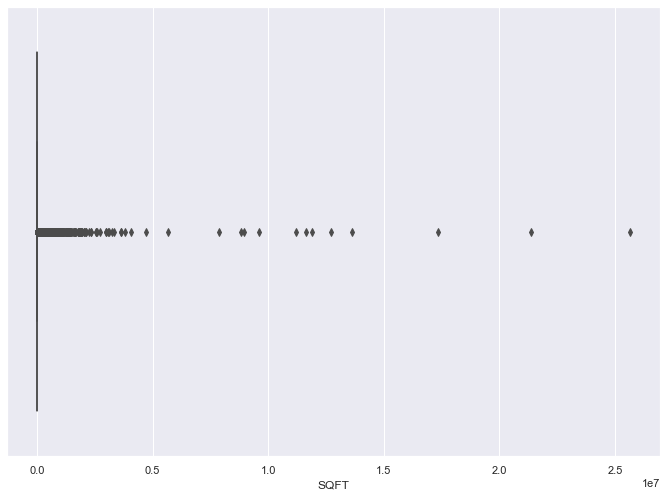

In [364]:
sns.boxplot(df.SQFT)

In [ ]:
sq = pd.DataFrame(df.SQFT.value_counts()).reset_index()
sq.head()
# sns.barplot(sq.index, sq.SQFT)

In [385]:
df.head()

PARCELNUM  govt_owned  detroit_owner  athome_owner   sold ZIP_CODE  \
0  08003860        True           True         False  False    48206   
1  08004437        True           True         False  False    48238   
2  08004879       False           True         False  False    48238   
3  08004903       False          False         False  False    48238   
4  08004922        True           True         False   True    48238   

       TAX_STATUS    SQFT  TOTAL_ACRE  FRONTAGE  DEPTH  NUM_BLDGS  SALE_PRICE  \
0  CITY LAND BANK  3136.0       0.072      30.0  104.0          0           0   
1  CITY LAND BANK  3000.0       0.060      30.0  100.0          0           0   
2         TAXABLE  3925.0       0.090      40.0   98.0          0           0   
3         TAXABLE  3485.0       0.080      35.0  100.0          1           0   
4  CITY LAND BANK  3485.0       0.080      35.0  100.0          0        3000   

   TXBL_VAL  LAND_VALUE ZONING  foreclosed  rental  total_due_parcel  \
0         0         479     R2           0       0               0.0   
1         0         424     R2           0       0               0.0   
2       400         890     R2           0       0               0.0   
3     12900         689     R2           0       0               0.0   
4         0         689     R2           0       0               0.0   

   total_tickets  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0

In [115]:
scaler.fit_transform(X)

ValueError: could not convert string to float: 

In [ ]:
z_t = blight.violation_zip_code.drop_duplicates('violation_zip_code').

z_b = blight.violation_zip_code.drop_duplicates('violation_zip_code').

In [ ]:
sns.distplot()

In [28]:
# i want to look at amount owed by zipcode
blight.plot()
blight.columns

Index(['X', 'Y', 'OBJECTID', 'ticket_id', 'ticket_number', 'agency_name',
       'inspector_name', 'violator_name', 'violation_street_number',
       'violation_street_name', 'violation_zip_code', 'violator_id',
       'mailing_address_str_number', 'mailing_address_str_name', 'city',
       'state', 'zip_code', 'non_us_str_code', 'country', 'violation_date',
       'ticket_issued_time', 'hearing_date', 'hearing_time', 'judgment_date',
       'violation_code', 'violation_description', 'disposition', 'fine_amount',
       'admin_fee', 'late_fee', 'discount_amount', 'clean_up_cost',
       'judgment_amount', 'payment_amount', 'balance_due', 'payment_date',
       'payment_status', 'collection_status', 'violation_address', 'parcelno',
       'total_tickets', 'total_due_parcel'],
      dtype='object')